**Import** Libraries

In [1]:
from __future__ import unicode_literals, print_function, division
import numpy as np


**Objective : Design RNN for predicting sequence of characters from training data**

In [2]:
class DataReader:
  def __init__(self):
    self.data = "You are a good boy"
    chars = list(set(self.data))
    # print(list(set(self.data)))
    chars.append(" ")
    #print(chars)
    self.char_to_ix = {ch:i for (i,ch) in enumerate(chars)}
    #print(self.char_to_ix)
    self.ix_to_char = {i:ch for (i,ch) in enumerate(chars)}
    self.seq_length = len(self.data)
    self.vocab_size = len(chars)
    #print(self.vocab_size)

  def get_inputs_targets(self, data):
   inputs_str = data
  
   target_str = data[1:]    
   target_str = target_str + " "
   inputs = [self.char_to_ix[ch] for ch in inputs_str] 
   targets = [self.char_to_ix[ch] for ch in target_str]
  #  print(inputs)
  #  print(targets)
   return inputs, targets

datareader = DataReader()
datareader.get_inputs_targets(datareader.data)


([10, 6, 8, 11, 5, 3, 0, 11, 5, 11, 1, 6, 6, 9, 11, 7, 6, 4],
 [6, 8, 11, 5, 3, 0, 11, 5, 11, 1, 6, 6, 9, 11, 7, 6, 4, 11])

**RNN** **Architecture**
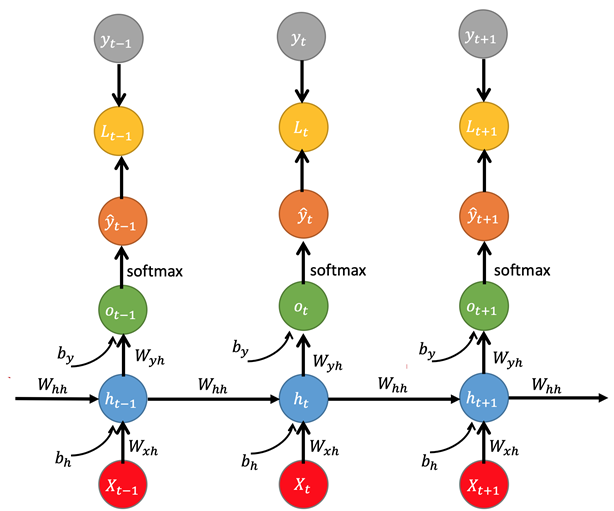

Softmax Modification to control overflow problems: 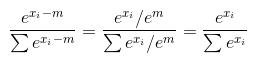

**RNN Forward Pass:**


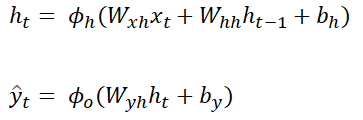

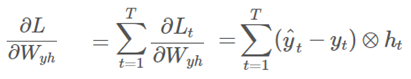

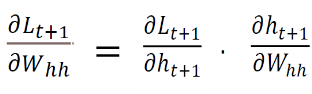

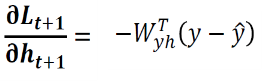

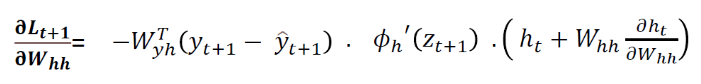

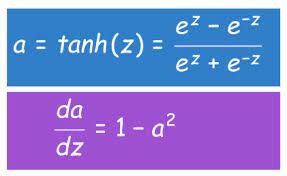

**Gradient Backpropgation via Recursion:**

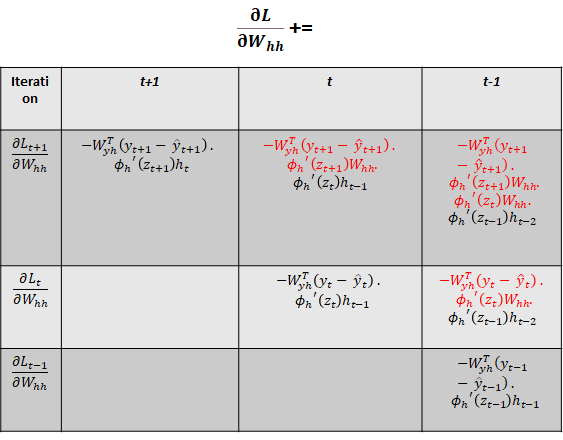

In [3]:

class RNN:
  def __init__(self, hidden_size, vocab_size,seq_length,learning_rate):
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.seq_length = seq_length
    self.learning_rate = learning_rate
    #print("RNN ", hidden_size,vocab_size,seq_length,learning_rate)
    # Model_Parameters
    self.W_xh = np.random.uniform(-np.sqrt(1./vocab_size),np.sqrt(1./vocab_size), size=(hidden_size,vocab_size))
    self.W_hh = np.random.uniform(-np.sqrt(1./hidden_size),np.sqrt(1./hidden_size), size=(hidden_size,hidden_size))
    self.W_yh = np.random.uniform(-np.sqrt(1./hidden_size),np.sqrt(1./hidden_size), size=(vocab_size,hidden_size))

    #### addittion :- 
###------------------------------------
    self.b = np.zeros((hidden_size, 1)) # bias for hidden layer
    self.c = np.zeros((vocab_size, 1)) # bias for output
###----------------------------------------
    ## memory variables
    self.mW_xh = np.zeros_like(self.W_xh)
    self.mW_hh = np.zeros_like(self.W_hh)
    self.mW_yh = np.zeros_like(self.W_yh)

    #### addittion 
### ----------------------------------------
    self.mb = np.zeros_like(self.b)
    self.mc = np.zeros_like(self.c)
###------------------------------------------

  
  def softmax(self, x):
    p = np.exp(x-np.max(x))
    return p / np.sum(p)


  def forward(self, inputs,hprev):
    xs, hs, os, ycap = {},{},{},{}
    hs[-1] = np.copy(hprev)
    for t in range(len(inputs)):
      xs[t] = np.zeros((self.vocab_size, 1))
      xs[t][inputs[t]] = 1 # one-hot encoding
      hs[t] = np.tanh(np.dot(self.W_hh,hs[t-1]) + np.dot(self.W_xh,xs[t])) 
      os[t] = np.dot(self.W_yh,hs[t])
      ycap[t] = self.softmax(os[t])
      #print(xs[t].shape,hs[t].shape,os[t].shape,ycap[t].shape)
    return xs, hs, ycap

  def loss(self, ycap, targets):
    return sum(-np.log(ycap[t][targets[t]]) for t in range(self.seq_length))

  def backward(self, xs, hs, ycap,targets):
    dW_xh = np.zeros_like(self.W_xh)
    dW_hh = np.zeros_like(self.W_hh)
    dW_yh = np.zeros_like(self.W_yh)
    ###addittion
    ###-------------------------
    db, dc = np.zeros_like(self.b), np.zeros_like(self.c)
    ###-----------------------
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(self.seq_length)):
      d_yy_cap = np.copy(ycap[t])
      d_yy_cap[targets[t]]-= 1
      dW_yh += np.dot(d_yy_cap,hs[t].T)
      ### addittion 
      ###----------------------
      dc += dc
      ###-----------------------
      dL_dh = np.dot(self.W_yh.T,d_yy_cap) + dhnext
      dL_dh_dtanh = (1 -hs[t]*hs[t])*dL_dh
      ###addittion 
      ###---------------
      db += dL_dh_dtanh

      dW_hh+= np.dot(dL_dh_dtanh, hs[t-1].T)
      dW_xh+= np.dot(dL_dh_dtanh, xs[t].T)

      dhnext = np.dot(self.W_hh.T,dL_dh_dtanh)

    return dW_xh, dW_hh, dW_yh ,db,dc     ### addittion of db ,dc in return statement

  def update_model(self, dW_xh, dW_hh, dW_yh,db,dc):   ### addittion of db,dc in the argument 
    for param, dparam in zip([self.W_xh, self.W_hh, self.W_yh,self.b,self.c],[dW_xh, dW_hh, dW_yh,db,dc]):   ### addittion 
      param+= -self.learning_rate*dparam

  def predict(self, data_reader, start_char, predict_len):
    x = np.zeros((self.vocab_size,1))
    ix = datareader.char_to_ix[start_char]
    x[ix] = 1
    indexes=[ix]
    hs = np.zeros((self.hidden_size, 1))
    for t in range(predict_len):
      hs = np.tanh(np.dot(self.W_hh,hs) + np.dot(self.W_xh,x) + self.b)
      os = np.dot(self.W_yh,hs) + self.c
      ycap = self.softmax(os)
      ix = np.random.choice(range(self.vocab_size), p = ycap.ravel()) 
      x = np.zeros((self.vocab_size, 1))
      x[ix]= 1
      indexes.append(ix)
    
    txt = ''.join(data_reader.ix_to_char[i] for i in indexes)
    print(txt)

  



datareader = DataReader()
inputs, targets = datareader.get_inputs_targets(datareader.data)
hidden_size = 50  #####################################################################################################
rnn1 = RNN(hidden_size,datareader.vocab_size,len(inputs), 1e-03)
print(rnn1.mW_xh)
hprev1= np.zeros((hidden_size, 1))
print(inputs)
xs1, hs1 , ycap1 = rnn1.forward(inputs,hprev1)
print(xs1)
# rnn.loss(ycap,targets)



########### on learning rate of 0.005 we are training our model..............################

rnn2 = RNN(hidden_size,datareader.vocab_size,len(inputs), 5 * 1e-03)
#print(rnn2.mW_xh)
hprev2= np.zeros((hidden_size, 1))
#print(inputs)
xs2, hs2 , ycap2 = rnn2.forward(inputs,hprev2)
#print(xs2)

###########  on learning rate of 0.012 we are training model ...............################

rnn3 = RNN(hidden_size,datareader.vocab_size,len(inputs), 12 * 1e-03)
#print(rnn3.mW_xh)
hprev3= np.zeros((hidden_size, 1))
#print(inputs)
xs3, hs3 , ycap3 = rnn3.forward(inputs,hprev3)
#print(xs3)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.

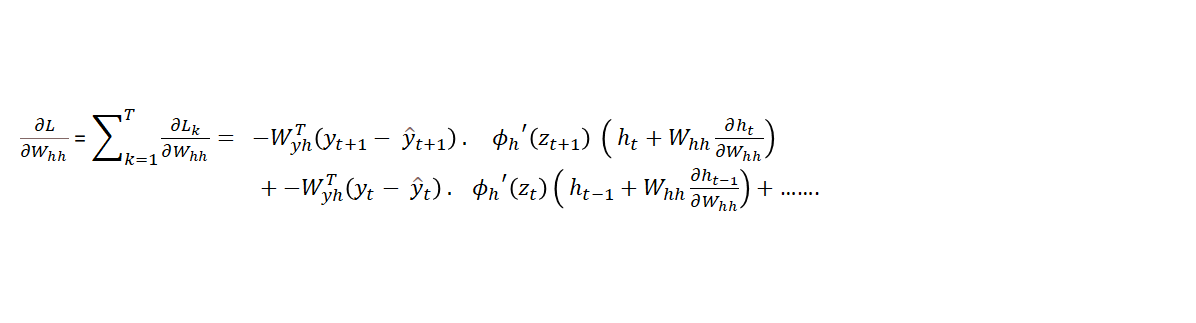

In [4]:
loss = 100
iter = 0
all_losses=[]
iteration=[]
while(iter < 5000):
  hprev= np.zeros((hidden_size, 1))
  xs1, hs1 , ycap1 = rnn1.forward(inputs,hprev)
  loss = rnn1.loss(ycap1, targets) 
  dW_xh, dW_hh, dW_yh,db,dc =  rnn1.backward(xs1, hs1 , ycap1,targets)   ###### additiion of db,dc 
  rnn1.update_model(dW_xh, dW_hh, dW_yh,db,dc)     ##### passing update_model with added db,dc
  if not iter%100:
    print("iter num", iter, loss)
    print(rnn1.predict(datareader,'Y', rnn1.seq_length))
    iteration.append(iter)
    all_losses.append(loss)
  iter+=1

iter num 0 [45.20178515]
Yrbg oerg aYoYYyYg 
None
iter num 100 [39.14530305]
YgrdYuooyr drr  gad
None
iter num 200 [30.16534088]
Yd g Y y   Ya beo  
None
iter num 300 [20.47245539]
Yau ad  od aooo  oo
None
iter num 400 [11.87178624]
Yyre ary   oo   oe 
None
iter num 500 [7.0559277]
Yad aob a y a gooy 
None
iter num 600 [4.64583054]
Yod aoa a gou gooy 
None
iter num 700 [3.30071575]
You aro a boy aoy a
None
iter num 800 [2.47588245]
You ary a good boy 
None
iter num 900 [1.93611501]
Yod boo  roodbbod a
None
iter num 1000 [1.56473857]
Yoa are a good aoy 
None
iter num 1100 [1.29847152]
You a e a gooddboy 
None
iter num 1200 [1.10085069]
You are a good boy 
None
iter num 1300 [0.94983439]
Yoa are a bood boy 
None
iter num 1400 [0.83153904]
You are a goou boy 
None
iter num 1500 [0.73689724]
You are a good ooy 
None
iter num 1600 [0.65979436]
You a e a goo  boy 
None
iter num 1700 [0.59598839]
You are a good aro 
None
iter num 1800 [0.54246153]
You are a good boy 
None
iter num 1900 [0.497

In [5]:
loss = 100
iter = 0
all_losses2=[]
iteration2=[]


while(iter < 5000):
  hprev2= np.zeros((hidden_size, 1))
  xs2, hs2 , ycap2 = rnn2.forward(inputs,hprev2)
  loss = rnn2.loss(ycap2, targets) 
  dW_xh, dW_hh, dW_yh,db,dc =  rnn2.backward(xs2, hs2 , ycap2,targets)
  rnn2.update_model(dW_xh, dW_hh, dW_yh,db,dc)
  if not iter%100:
    print("iter num", iter, loss)
    print(rnn2.predict(datareader,'Y', rnn2.seq_length))
    iteration2.append(iter)
    all_losses2.append(loss)
  iter+=1

iter num 0 [45.4147401]
Ybubrbbygrey daYd e
None
iter num 100 [7.4586243]
Y   are a good eod 
None
iter num 200 [2.02395744]
You are a eoo  bou 
None
iter num 300 [0.91211755]
You are a good aoy 
None
iter num 400 [0.55009207]
You a e a boy gboy 
None
iter num 500 [0.38484791]
You are a bood boy 
None
iter num 600 [0.29264685]
You are a good boy 
None
iter num 700 [0.23452154]
You are a good boy 
None
iter num 800 [0.19480376]
Yoo broo  boy  oou 
None
iter num 900 [0.16607611]
You are a good boy 
None
iter num 1000 [0.14440182]
You are a bood boy 
None
iter num 1100 [0.12750822]
You are o good goy 
None
iter num 1200 [0.11399602]
You a e a good ooy 
None
iter num 1300 [0.1029588]
You are o bood aou 
None
iter num 1400 [0.09378471]
You a god  ood boo 
None
iter num 1500 [0.08604642]
You are a good boy 
None
iter num 1600 [0.07943687]
You are a good boy 
None
iter num 1700 [0.07372994]
You are a good boy 
None
iter num 1800 [0.06875557]
You are a good boy 
None
iter num 1900 [0.06438354]

In [6]:
loss = 100
all_losses3=[]
iteration3=[]
iter = 0

while(iter < 5000):
  hprev3= np.zeros((hidden_size, 1))
  xs3, hs3 , ycap3 = rnn3.forward(inputs,hprev3)
  loss = rnn3.loss(ycap3, targets) 
  dW_xh, dW_hh, dW_yh,db,dc =  rnn3.backward(xs3, hs3 , ycap3,targets)
  rnn3.update_model(dW_xh, dW_hh, dW_yh,db,dc)
  if not iter%100:
    print("iter num", iter, loss)
    print(rnn3.predict(datareader,'Y', rnn3.seq_length))
    iteration3.append(iter)
    all_losses3.append(loss)
  iter+=1

iter num 0 [44.8950294]
YradbYydaeuao aduuy
None
iter num 100 [1.1609613]
You are a good bou 
None
iter num 200 [0.35207813]
You aoe a good boY 
None
iter num 300 [0.19704955]
You are a good boy 
None
iter num 400 [0.13469321]
You are a good boy 
None
iter num 500 [0.10156372]
You are a good boy 
None
iter num 600 [0.08116769]
You are a good boy 
None
iter num 700 [0.06740717]
You are a good boy 
None
iter num 800 [0.057525]
You are abgood boy 
None
iter num 900 [0.05009877]
You are a good boy 
None
iter num 1000 [0.04432257]
You are a good boy 
None
iter num 1100 [0.03970664]
You are a good boy 
None
iter num 1200 [0.03593664]
You are a good boy 
None
iter num 1300 [0.0328018]
You are a good boy 
None
iter num 1400 [0.03015566]
You are a oood boy 
None
iter num 1500 [0.02789332]
You are a good boy 
None
iter num 1600 [0.02593777]
You are a good boy 
None
iter num 1700 [0.02423119]
You are a oood boy 
None
iter num 1800 [0.02272935]
You are a good boy 
None
iter num 1900 [0.02139787]
Y

In [7]:
import matplotlib.pyplot as plt

In [8]:
import torch

tensor1 = torch.tensor(all_losses,requires_grad=True)
tensor1 = tensor1.detach().numpy()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
tensor2 = torch.tensor(all_losses2,requires_grad=True)
tensor2 = tensor2.detach().numpy()

In [10]:
tensor3 = torch.tensor(all_losses3,requires_grad=True)
tensor3 = tensor3.detach().numpy()

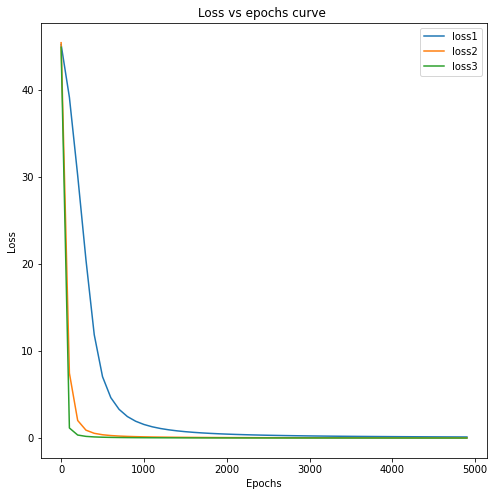

In [11]:
plt.figure(figsize=(8,8))
plt.title("Loss vs epochs curve ")
plt.plot(iteration,tensor1,label="loss1")
plt.plot(iteration2,tensor2,label="loss2")
plt.plot(iteration3,tensor3,label="loss3")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()